# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on PFC cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [2]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)
from scipy import sparse

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [4]:

mtx_path=r"/temp/data/human_MDD_PFC/GSE144136_GeneBarcodeMatrix_Annotated.mtx"
cell_name_path=r"/temp/data/human_MDD_PFC/GSE144136_CellNames.csv"
gene_name_path=r"/temp/data/human_MDD_PFC/GSE144136_GeneNames.csv"

genes = pd.read_csv(gene_name_path)
cells = pd.read_csv(cell_name_path)
adata=sc.read_mtx(mtx_path)
adata=adata.T
adata.obs_names = cells.x
adata.var_names = genes.x
adata.X=sparse.csr_matrix(adata.X)
adata.write("/temp/data/human_MDD_PFC/merged_data.h5ad")
#arr = scipy.io.mmread(mtx_path).tocsr()

In [6]:
print(adata.X)
#print(adata.obs_names)
print(genes.x)

  (0, 4)	1.0
  (0, 12)	1.0
  (0, 36)	1.0
  (0, 43)	4.0
  (0, 75)	1.0
  (0, 81)	1.0
  (0, 89)	1.0
  (0, 99)	1.0
  (0, 114)	1.0
  (0, 131)	1.0
  (0, 143)	1.0
  (0, 148)	2.0
  (0, 176)	1.0
  (0, 177)	1.0
  (0, 195)	1.0
  (0, 217)	1.0
  (0, 233)	1.0
  (0, 245)	1.0
  (0, 266)	1.0
  (0, 270)	1.0
  (0, 282)	1.0
  (0, 284)	1.0
  (0, 311)	1.0
  (0, 322)	1.0
  (0, 329)	1.0
  :	:
  (78885, 29417)	1.0
  (78885, 29422)	1.0
  (78885, 29431)	1.0
  (78885, 29497)	1.0
  (78885, 29509)	1.0
  (78885, 29515)	1.0
  (78885, 29524)	2.0
  (78885, 29556)	2.0
  (78885, 29584)	1.0
  (78885, 29680)	1.0
  (78885, 29681)	2.0
  (78885, 29707)	3.0
  (78885, 29739)	2.0
  (78885, 29741)	2.0
  (78885, 29765)	1.0
  (78885, 29768)	2.0
  (78885, 29786)	2.0
  (78885, 29806)	1.0
  (78885, 29832)	1.0
  (78885, 29835)	1.0
  (78885, 29871)	4.0
  (78885, 29878)	1.0
  (78885, 29885)	1.0
  (78885, 29996)	1.0
  (78885, 30040)	2.0
0         RP11-34P13.3
1         RP11-34P13.7
2        RP11-34P13.14
3           FO538757.3
4          

In [6]:
celltype_df=pd.DataFrame(cells.x.str.split(".",expand=True))
barcode_df=celltype_df.iloc[:,1].str.split("_",expand=True)
barcode_df2=pd.concat([celltype_df.iloc[:,0],barcode_df],axis=1)
barcode_df2=barcode_df2.set_axis(["celltype","subject","case_control","batch","barcode"],axis="columns")
b_df3=barcode_df2.copy()
b_df3.index=adata.obs.index
obs_col=["celltype","subject","case_control","batch","barcode"]

NameError: name 'adata' is not defined

## Create list of GPCR

In [3]:
HTR_list=genes[genes.iloc[:,1].str.startswith("HTR",na=False)].x
DRD_list=genes[genes.iloc[:,1].str.startswith("DRD",na=False)].x
ADR_list=genes[genes.iloc[:,1].str.startswith("ADR",na=False)].x
HRH_list=genes[genes.iloc[:,1].str.startswith("HRH",na=False)].x
CHRM_list=genes[genes.iloc[:,1].str.startswith("CHRM",na=False)].x

GPCR_list=pd.concat([HTR_list,DRD_list,ADR_list,HRH_list,CHRM_list])
GPCR_list=GPCR_list.sort_values()
GPCR_list=GPCR_list[~GPCR_list.str.endswith("AS1")]
GPCR_list=GPCR_list[~GPCR_list.str.endswith("AS2")]
exclude=["ADRBK1","ADRBK2","ADRM1","ADRB3","HTRA1","HTRA2","HTRA3","HTRA4","HTR3A","HTR3B",
         "HTR3C","HTR3D","HTR3E","HRH4","HTR1F","HTR5A","ADRA1D"] #HTR3はcation channel
GPCR_list=GPCR_list[~GPCR_list.isin(exclude)]
GPCR_df=pd.DataFrame({"receptor_name":GPCR_list}).reset_index(drop=True)
GPCR_df["type"]="Gs"
Gi_list=["ADRA2A","ADRA2B","ADRA2C","CHRM2","CHRM4","DRD2","DRD3","DRD4","HRH3","HRH4",
         "HTR1A","HTR1B","HTR1D","HTR1E","HTR1F","HTR5A"]
Gq_list=["ADRA1A","ADRA1B","ADRA1D","CHRM1","CHRM3","CHRM5","HRH1","HTR2A","HTR2B","HTR2C"]
GPCR_df.loc[GPCR_df.receptor_name.isin(Gi_list),"type"]="Gi"
GPCR_df.loc[GPCR_df.receptor_name.isin(Gq_list),"type"]="Gq"

NameError: name 'genes' is not defined

## Set parameters

In [4]:
drug_receptor_mtx=pd.read_csv("../data/Antipsychotics/drug_receptor_mtx.csv")
GPCR_df=pd.read_csv("../data/Antipsychotics/GPCR_df.csv")

In [5]:
print(drug_receptor_mtx.columns)
d_r_column=drug_receptor_mtx.columns
d_r_column_rep=['Ligand',"HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]

drug_receptor_mtx.columns=d_r_column_rep
drug_receptor_mtx=drug_receptor_mtx.set_index("Ligand")
#print(drug_receptor_mtx.columns)

Index(['Ligand', '5-HT1A', '5-HT1B', '5-HT1D', '5-HT1E', '5-HT2A', '5-HT2B',
       '5-HT2C', '5-HT3', '5-HT4', '5-HT5', '5HT6', '5HT7', 'D1', 'D2', 'D3',
       'D4', 'D5', 'H1', 'H2', 'H3', 'M1', 'M2', 'M3', 'M4', 'M5', 'alpha1A',
       'alpha1B', 'alpha2A', 'alpha2B', 'alpha2C', 'beta1', 'beta2'],
      dtype='object')


In [6]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CX3CR1","CLDN5","GLUL","NDRG2","PCDH15","PLP1","MBP","SATB2","SLC17A7",
"SLC17A6","GAD2","GAD1","SNAP25"] # Marker genes for visualization

marker_genes_dict = {'Excitatroy neuron': ["SATB2",'SLC17A6', 'SLC17A7'],
                     'Inhibitory neuron':  ['GAD1', 'GAD2'],
                     'Neuron': ["SNAP25"],
                     'Endothelial cells': ["CLDN5"],
                     'Astrocyte': ['GLUL', 'NDRG2'],
                     'Oligodendrocyte': ['PLP1', 'MBP'],
                     'Microglia': ['CX3CR1']}
#print(d_r_column_rep[1:])
markers.extend(d_r_column_rep[1:])
markers = [str.upper() for str in markers]
markers.remove("HTR1E")
# filtering cells
min_genes_per_cell = 800 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 20

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [91]:
start = time.time()

In [7]:
D_R_mtx=pd.read_csv("../data/Antipsychotics/drug_receptor_mtx.csv")
GPCR_type_df=pd.read_csv("../data/Antipsychotics/GPCR_df.csv")

In [8]:
print(D_R_mtx.columns)
d_r_column=D_R_mtx.columns
d_r_column_rep=['Ligand',"HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]

D_R_mtx.columns=d_r_column_rep
D_R_mtx=D_R_mtx.set_index("Ligand")
#print(drug_receptor_mtx.columns)

Index(['Ligand', '5-HT1A', '5-HT1B', '5-HT1D', '5-HT1E', '5-HT2A', '5-HT2B',
       '5-HT2C', '5-HT3', '5-HT4', '5-HT5', '5HT6', '5HT7', 'D1', 'D2', 'D3',
       'D4', 'D5', 'H1', 'H2', 'H3', 'M1', 'M2', 'M3', 'M4', 'M5', 'alpha1A',
       'alpha1B', 'alpha2A', 'alpha2B', 'alpha2C', 'beta1', 'beta2'],
      dtype='object')


In [8]:
GPCR_list=d_r_column_rep[1:]

In [22]:
%%time
GPCR_df=pd.DataFrame()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    if   name[:-4] in GPCR_list:
        GPCR_df[name]=data.get()

NameError: name 'marker_genes_raw' is not defined

In [28]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
#print(GPCR_adata.X.shape)
GPCR_adata.obs=pd.DataFrame(GPCR_df.index)
GPCR_adata.var=pd.DataFrame(GPCR_df.columns)

ValueError: no types given

In [ ]:
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']

In [29]:
norm_df=pd.DataFrame(GPCR_adata_norm)
norm_col=[str[:-4] for str in GPCR_df.columns]
#print(norm_col)
norm_df.columns=norm_col
print(norm_df)

NameError: name 'GPCR_adata_norm' is not defined

In [18]:
print(GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)])
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]

NameError: name 'GPCR_type_df' is not defined

In [9]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

#print(Gs)
#print(GPCR_adata_norm)
drug_list=D_R_mtx.index.to_list()
#print(drug_list)
#drug_receptor_mtx
cAMP_df=pd.DataFrame(columns=drug_list)
Ca_df=pd.DataFrame(columns=drug_list)
for drug in drug_list:
    Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
    Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
    Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
    cAMPmod=Gi_effect-Gs_effect #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下
    Camod=-Gq_effect #Gq阻害→Ca低下
    cAMP_df[drug]=cAMPmod
    Ca_df[drug]=Camod

NameError: name 'norm_df' is not defined

## Load and Preprocess Data

We load the sparse count matrix from an `csv` file using Scanpy. 

In [92]:
preprocess_start = time.time()

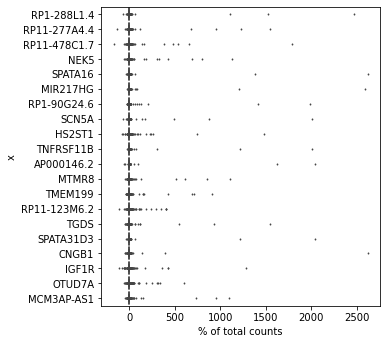

In [53]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [18]:
genes = cudf.Series(adata.var_names).str.upper()
print(genes)
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

0         RP11-34P13.3
1         RP11-34P13.7
2        RP11-34P13.14
3           FO538757.3
4           FO538757.2
             ...      
30057       AL354822.1
30058       AC023491.2
30059       AC004556.1
30060       AC240274.1
30061          FAM231B
Name: x, Length: 30062, dtype: object


Verify the shape of the resulting sparse matrix:

In [56]:
sparse_gpu_array.shape

(57050, 29993)

And the number of non-zero values in the matrix:

In [57]:
sparse_gpu_array.nnz

1711100650

In [21]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 744 ms, sys: 372 ms, total: 1.12 s
Wall time: 1.11 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [22]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=min_cells_per_gene)

CPU times: user 1.05 s, sys: 108 ms, total: 1.16 s
Wall time: 1.15 s


The size of our count matrix is now reduced.

In [19]:
sparse_gpu_array.shape

(57050, 29993)

In [11]:
#len(genes)
drug_list=D_R_mtx.index.to_list()

In [38]:
import pandas as pd
df=genes.to_pandas()
#print(df)
#df.to_csv("../data/SFO/genes.csv")
for marker in markers:
    if not marker in df.values:
        print("%s is not included"%marker)
        markers.remove(marker)
        print("%s is removed from marker list"%marker)

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [39]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

NameError: name 'sparse_gpu_array' is not defined

### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [ ]:
%%time
mito_genes = genes.str.startswith(MITO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 20.1 ms, sys: 2 µs, total: 20.1 ms
Wall time: 18.3 ms


In [ ]:
print(percent_mito)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

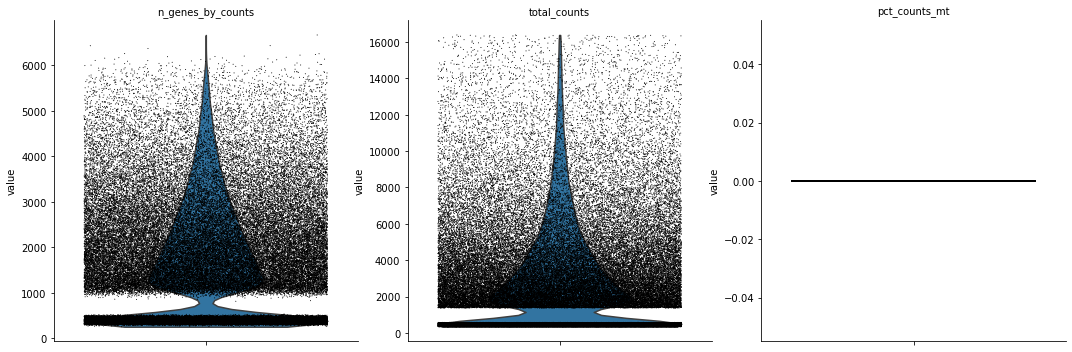

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

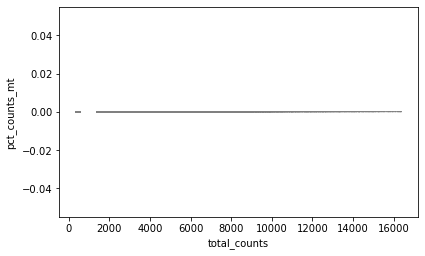

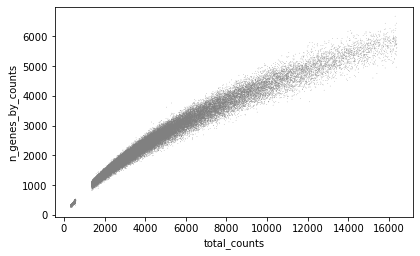

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

And perform regression:

In [7]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array.tocsc(), n_counts, percent_mito)
del n_counts, percent_mito, mito_genes

NameError: name 'sparse_gpu_array' is not defined

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [25]:
%%time
mean = sparse_gpu_array.mean(axis=0)
sparse_gpu_array -= mean
stddev = cp.sqrt(sparse_gpu_array.var(axis=0))
sparse_gpu_array /= stddev
sparse_gpu_array = sparse_gpu_array.clip(a_max=10)
del mean, stddev

CPU times: user 4.39 s, sys: 1.14 s, total: 5.54 s
Wall time: 5.53 s


In [63]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

NameError: name 'preprocess_start' is not defined

## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [26]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
del sparse_gpu_array, genes

CPU times: user 1.15 s, sys: 944 ms, total: 2.1 s
Wall time: 2.09 s


In [27]:
%%time
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 45.6 ms, sys: 60 µs, total: 45.6 ms
Wall time: 43.7 ms


## Calculate response to antipsychotics in each cells

In [28]:
%%time
GPCR_df=pd.DataFrame()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    if   name[:-4] in GPCR_list:
        GPCR_df[name]=data.get()

CPU times: user 34.5 ms, sys: 19.9 ms, total: 54.4 ms
Wall time: 52.4 ms


In [29]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
#print(GPCR_adata.X.shape)
GPCR_adata.obs=pd.DataFrame(GPCR_df.index)
GPCR_adata.var=pd.DataFrame(GPCR_df.columns)

In [30]:
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']

In [31]:
norm_df=pd.DataFrame(GPCR_adata_norm)
norm_col=[str[:-4] for str in GPCR_df.columns]
#print(norm_col)
norm_df.columns=norm_col
print(norm_df)

       HTR1A  HTR1B  HTR1D        HTR2A  HTR2B   HTR2C  HTR3A  HTR4  HTR5A  \
0        0.0    0.0    0.0  1111.111084    0.0     0.0    0.0   0.0    0.0   
1        0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   
2        0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   
3        0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   
4        0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   
...      ...    ...    ...          ...    ...     ...    ...   ...    ...   
57045    0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   
57046    0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   
57047    0.0    0.0    0.0  5000.000000    0.0     0.0    0.0   0.0    0.0   
57048    0.0    0.0    0.0     0.000000    0.0  1250.0    0.0   0.0    0.0   
57049    0.0    0.0    0.0     0.000000    0.0     0.0    0.0   0.0    0.0   

       HTR6  ...         CHRM3  CHRM4        CHRM5  ADRA1A     

In [32]:
print(GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)])
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]

    Unnamed: 0 receptor_name type
0            0        ADRA1A   Gq
1            1        ADRA1B   Gq
2            2        ADRA2A   Gi
3            3        ADRA2B   Gi
4            4        ADRA2C   Gi
5            5         ADRB1   Gs
6            6         ADRB2   Gs
7            7         CHRM1   Gq
8            8         CHRM2   Gi
9            9         CHRM3   Gq
10          10         CHRM4   Gi
11          11         CHRM5   Gq
12          12          DRD1   Gs
13          13          DRD2   Gi
14          14          DRD3   Gi
15          15          DRD4   Gi
16          16          DRD5   Gs
17          17          HRH1   Gq
18          18          HRH2   Gs
19          19          HRH3   Gi
20          20         HTR1A   Gi
21          21         HTR1B   Gi
22          22         HTR1D   Gi
24          24         HTR2A   Gq
25          25         HTR2B   Gq
26          26         HTR2C   Gq
27          27          HTR4   Gs
28          28          HTR6   Gs
29          29

In [33]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

#print(Gs)
#print(GPCR_adata_norm)
drug_list=D_R_mtx.index.to_list()
#print(drug_list)
#drug_receptor_mtx
cAMP_df=pd.DataFrame(columns=drug_list)
Ca_df=pd.DataFrame(columns=drug_list)
for drug in drug_list:
    Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
    Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
    Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
    cAMPmod=Gi_effect-Gs_effect #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下
    Camod=-Gq_effect #Gq阻害→Ca低下
    cAMP_df[drug]=cAMPmod
    Ca_df[drug]=Camod

In [34]:
cAMP_df.index=adata.obs_names
Ca_df.index=adata.obs_names
Ca_df=Ca_df+10**(-4)
for drug in drug_list:
    adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
    adata.obs['Ca_%s'%drug]=Ca_df[drug]

In [31]:
print(adata.X.dtype)
print(adata.X)

float32
[[-0.02840713 -0.10537276 -0.00418674 ... -0.06975794 -0.165404
  -0.00418674]
 [-0.02840713 -0.10537276 -0.00418674 ... -0.06975794 -0.165404
  -0.00418674]
 [-0.02840713 -0.10537276 -0.00418674 ... -0.06975794 -0.165404
  -0.00418674]
 ...
 [-0.02840713 -0.10537276 -0.00418674 ... -0.06975794 -0.165404
  -0.00418674]
 [-0.02840713 -0.10537276 -0.00418674 ... -0.06975794 -0.165404
  -0.00418674]
 [-0.02840713 -0.10537276 -0.00418674 ... -0.06975794 -0.165404
  -0.00418674]]


### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [35]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 12min 20s, sys: 28 s, total: 12min 48s
Wall time: 49.7 s


The UMAP function from Rapids is also integrated into Scanpy.

In [36]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 265 ms, sys: 96 ms, total: 361 ms
Wall time: 358 ms


Next, we use the Louvain algorithm for graph-based clustering.

In [37]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 96.5 ms, sys: 4.17 ms, total: 101 ms
Wall time: 99.3 ms


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

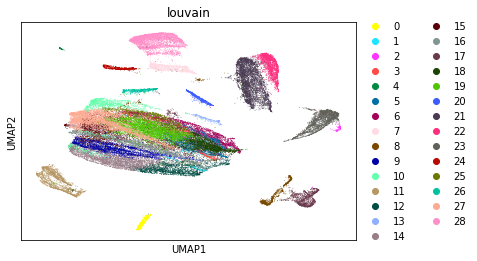

CPU times: user 638 ms, sys: 16.4 ms, total: 654 ms
Wall time: 651 ms


In [19]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [14]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 1.71 s, sys: 1.02 s, total: 2.73 s
Wall time: 3.66 s


In [1]:
%%time
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6), gridspec_kw={'wspace':0.2})
sc.pl.umap(adata, color=["leiden"],ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/human_PFC/pdf/umap_cluster.pdf",bbox_inches='tight')
fig.savefig("../data/human_PFC/pdf/umap_cluster.png",bbox_inches='tight')
plt.close()

NameError: name 'plt' is not defined

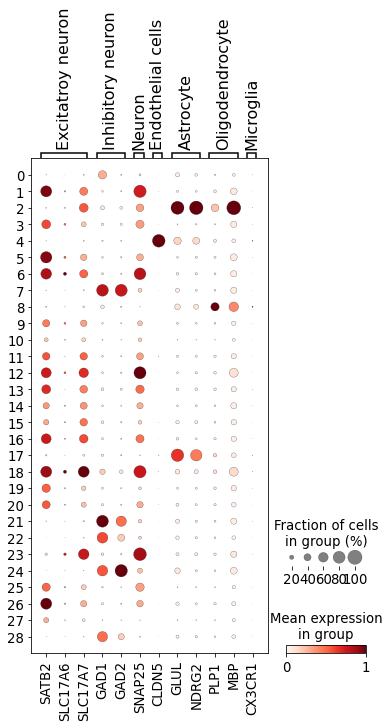

CPU times: user 1.1 s, sys: 144 ms, total: 1.25 s
Wall time: 1.1 s


In [27]:
%%time
fig=plt.figure(figsize=(6,10))
ax1= fig.add_subplot(1,1,1)
sc.pl.dotplot(adata,marker_genes_dict, groupby="leiden",ax=ax1, standard_scale='var')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/human_PFC/pdf/marker_expression.pdf",bbox_inches='tight')
fig.savefig("../data/human_PFC/pdf/marker_expression.png",bbox_inches='tight')
plt.close()

NameError: name 'GPCR_list' is not defined

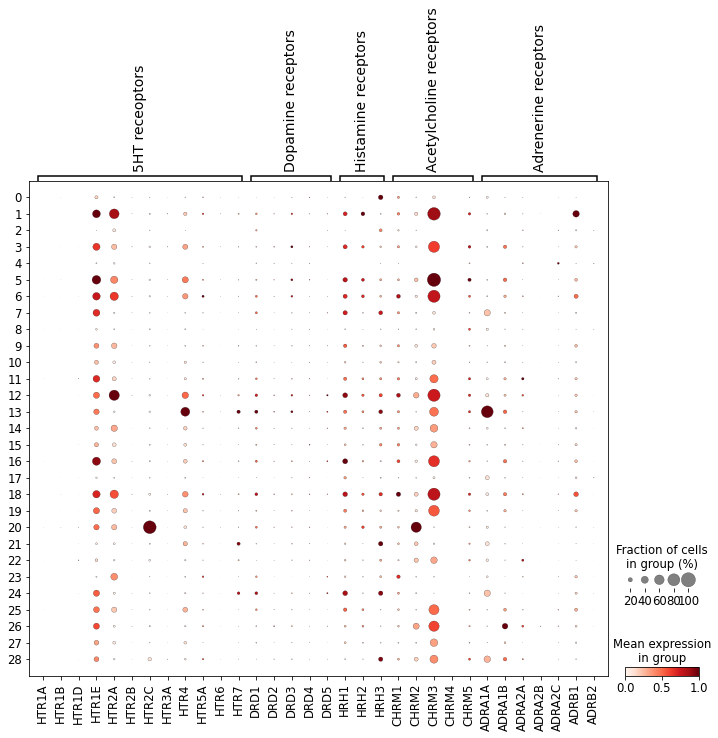

CPU times: user 1.38 s, sys: 160 ms, total: 1.54 s
Wall time: 1.39 s


In [28]:
%%time
GPCR_dict = {'5HT receoptors': ["HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7"],
                     'Dopamine receptors':  ["DRD1","DRD2","DRD3","DRD4","DRD5"],
                     'Histamine receptors': ["HRH1","HRH2","HRH3"],
                     'Acetylcholine receptors': ["CHRM1","CHRM2","CHRM3","CHRM4","CHRM5"],
                     'Adrenerine receptors': ["ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]}
fig=plt.figure(figsize=(12,10))
ax1= fig.add_subplot(1,1,1)
sc.pl.dotplot(adata,GPCR_dict, groupby="leiden",ax=ax1, standard_scale='var')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/human_PFC/pdf/GPCR_expression.pdf",bbox_inches='tight')
fig.savefig("../data/human_PFC/pdf/GPCR_expression.png",bbox_inches='tight')
plt.close()

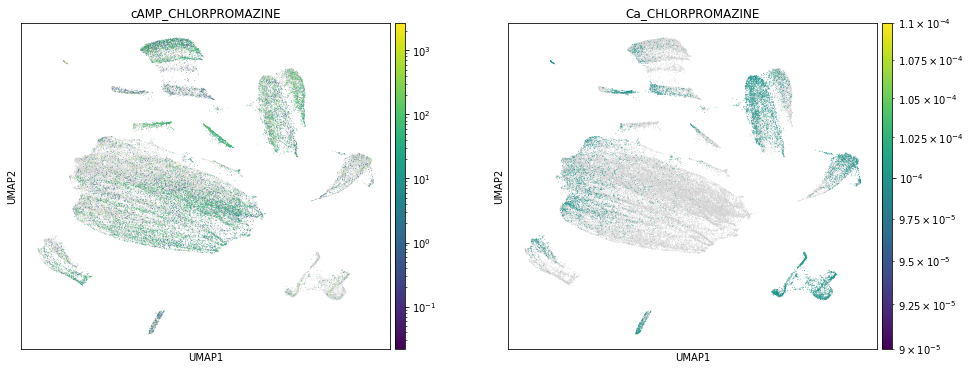

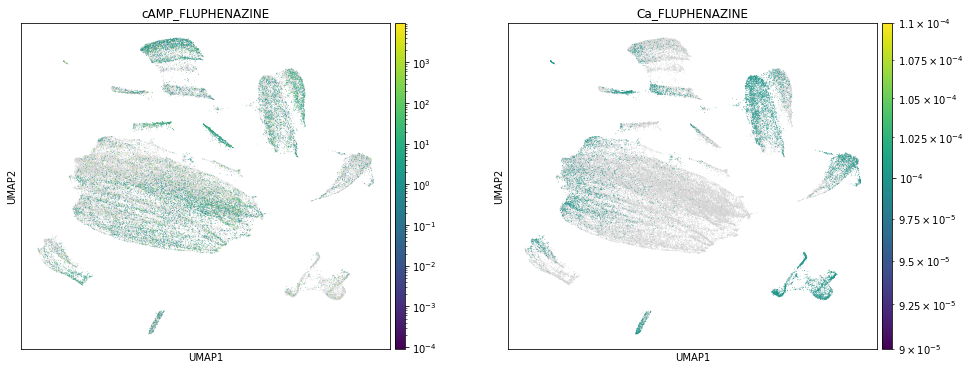

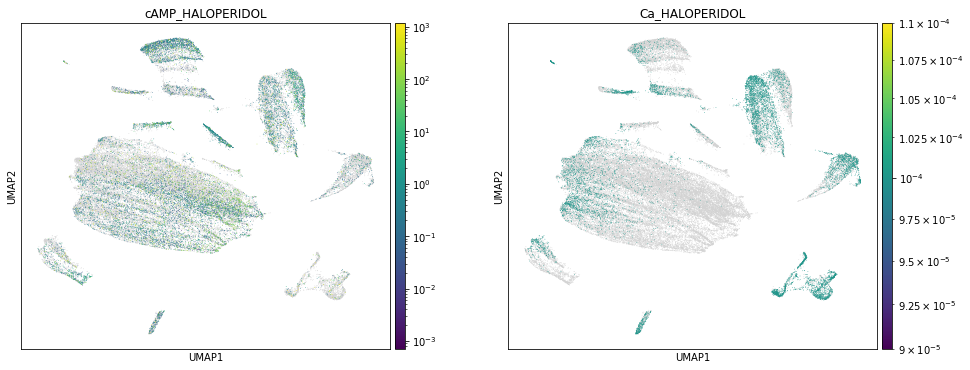

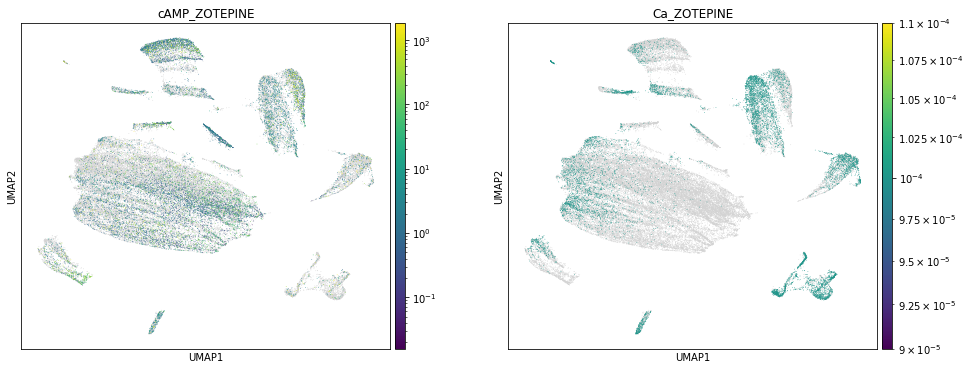

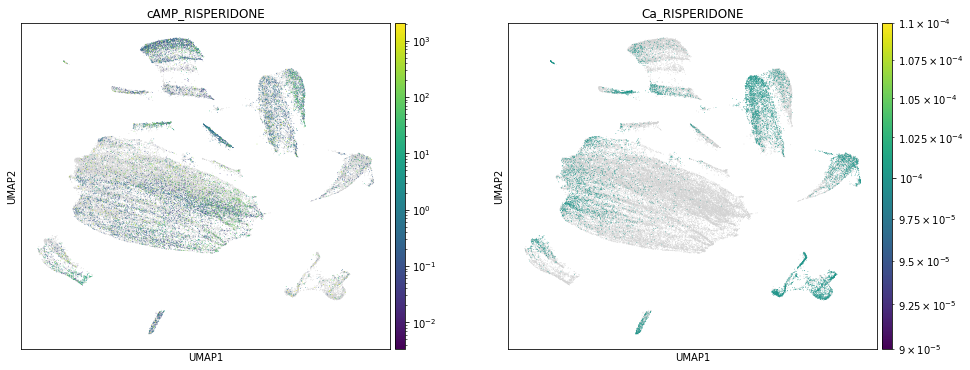

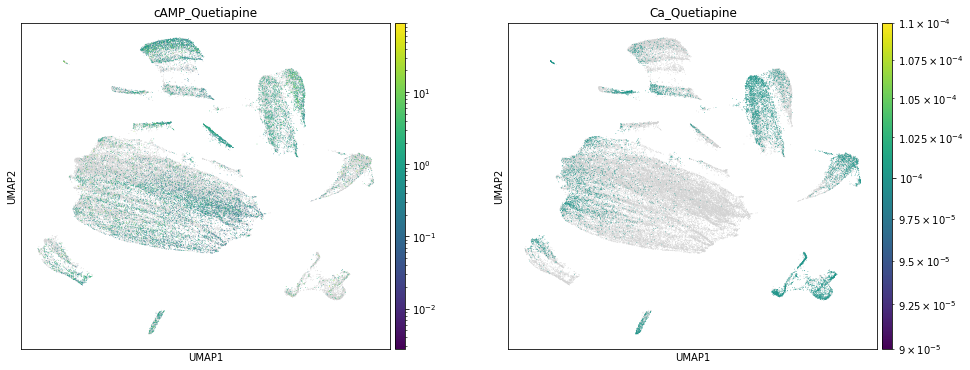

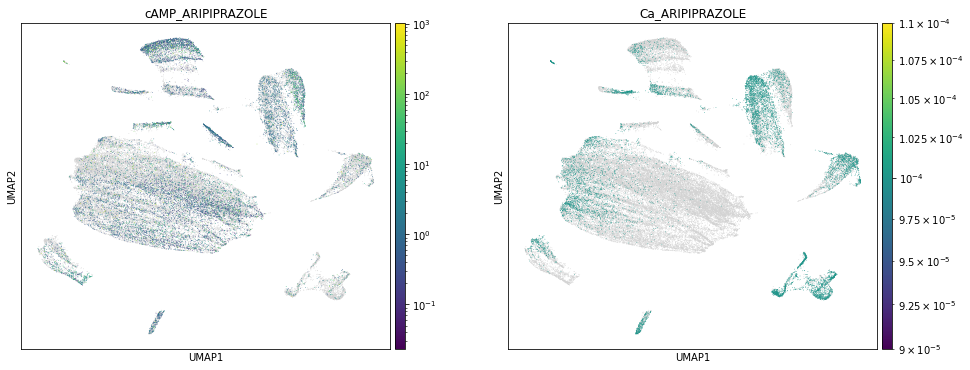

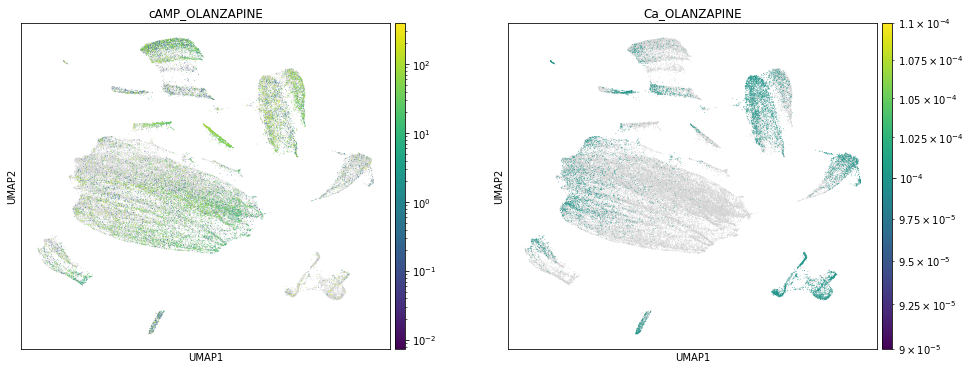

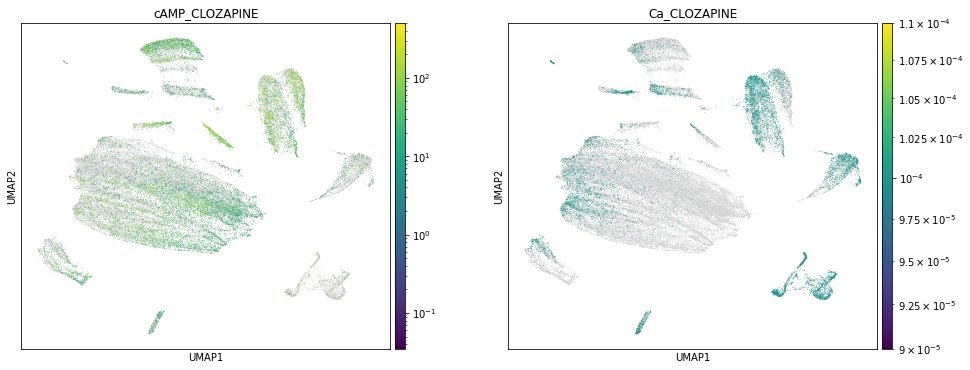

In [42]:
for drug in drug_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'wspace':0.2})
    ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(),ax=ax1, show=False)
    ax2_dict = sc.pl.umap(adata, color=["Ca_%s"%drug],norm=LogNorm(),ax=ax2, show=False)

In [41]:
len(drug_list)

9

In [15]:
import matplotlib.colors as colors
plt.rcParams["font.size"] = 16
fig,(ax_list) = plt.subplots(1, 9, figsize=(66,6), gridspec_kw={'wspace':0.3})
for idx,drug in enumerate(drug_list):
    ax=ax_list[idx]
    color_bar_option="None"
    if idx==len(ax_list):
        color_bar_option="right"
    ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=colors.SymLogNorm(linthresh=1, linscale=0.2,
                                           vmin=-1E+3, vmax=1E+3, base=10),ax=ax_list[idx], show=False,color_map="PiYG")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(vmin=1E-1,vmax=1E+3),ax=ax_list[idx], show=False,color_map="bwr")
    #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
    #                                          vmin=-1.0, vmax=1.0, base=10)
fig.savefig("../data/human_PFC/pdf/cAMP_response.pdf")
fig.savefig("../data/human_PFC/pdf/cAMP_response.png")
plt.close()

And we can visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

In [28]:
len(markers)

44

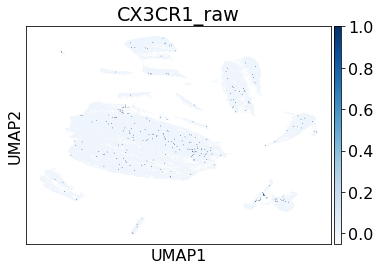

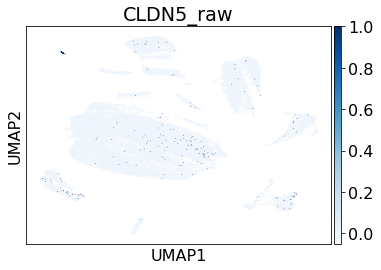

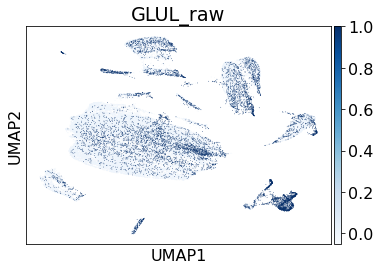

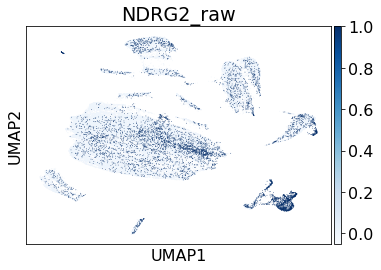

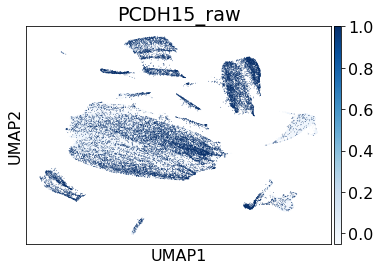

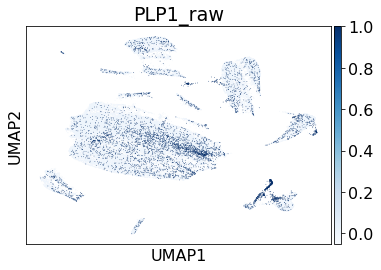

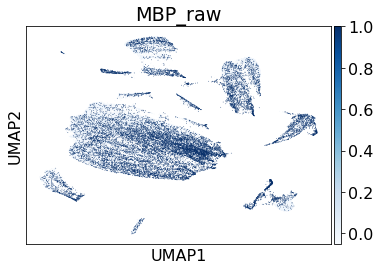

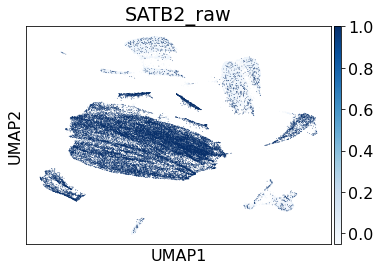

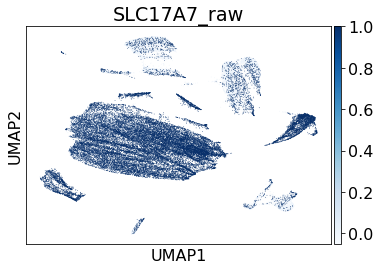

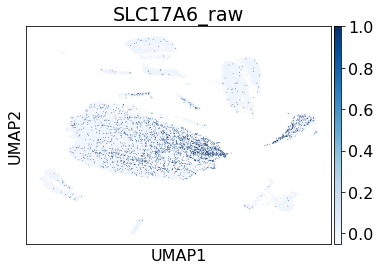

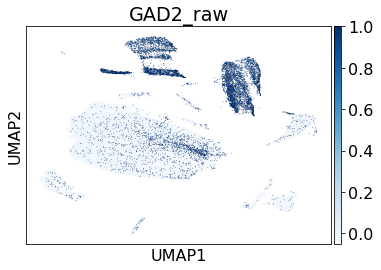

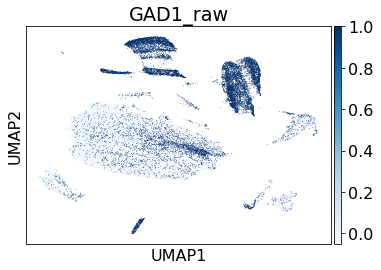

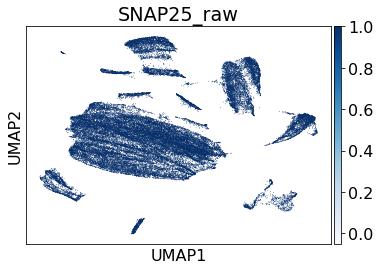

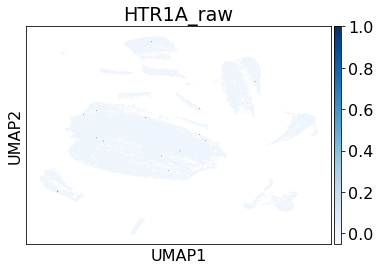

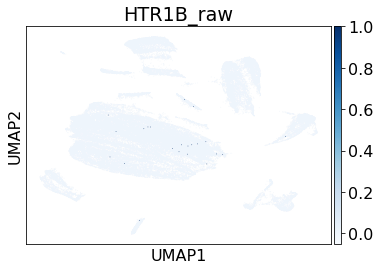

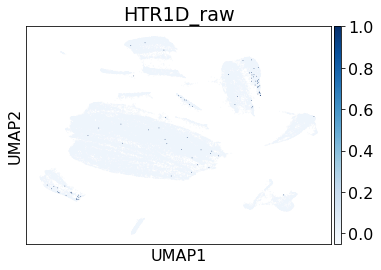

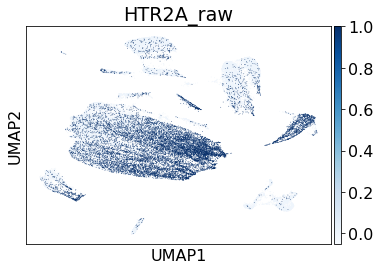

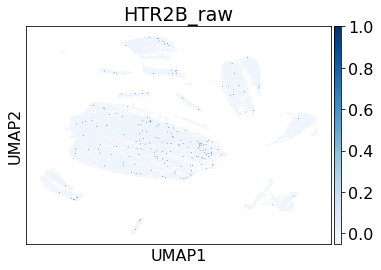

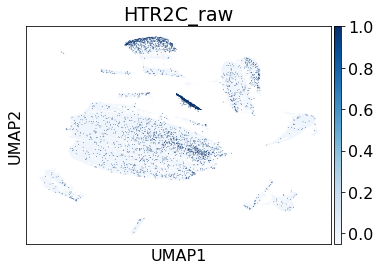

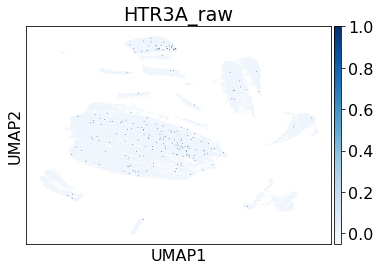

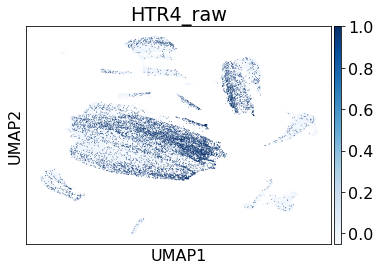

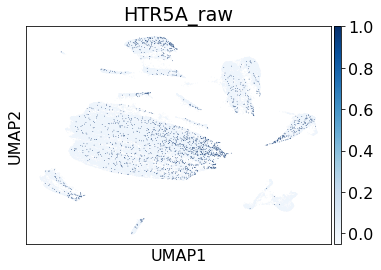

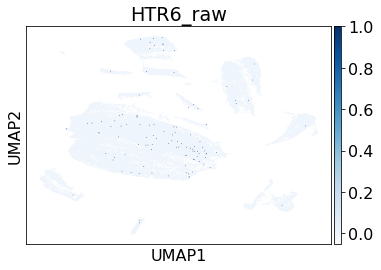

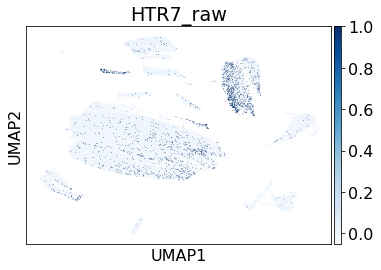

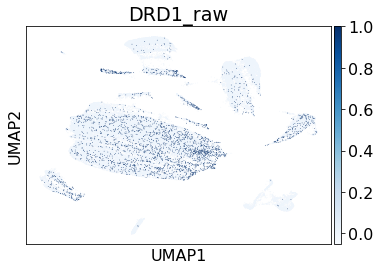

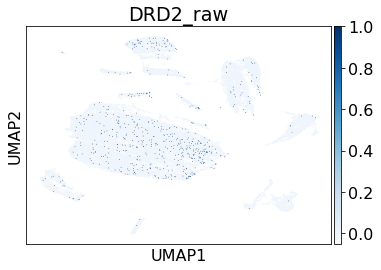

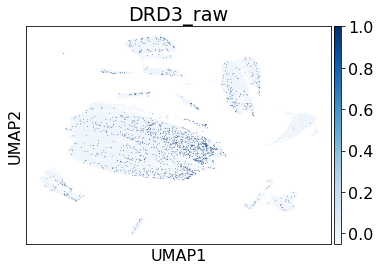

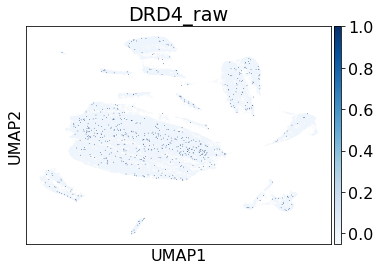

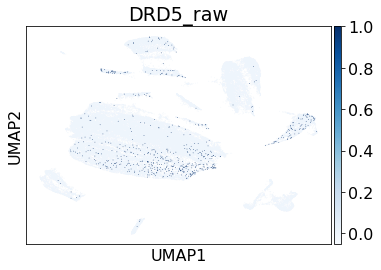

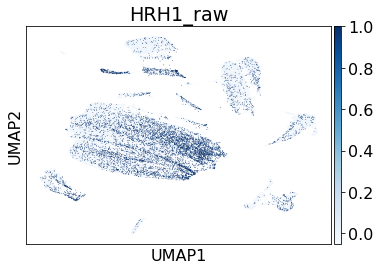

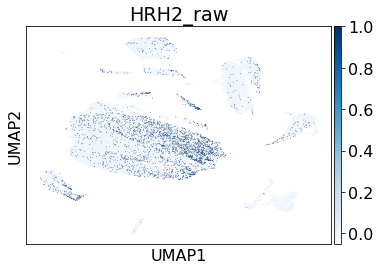

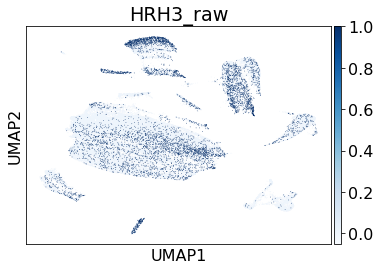

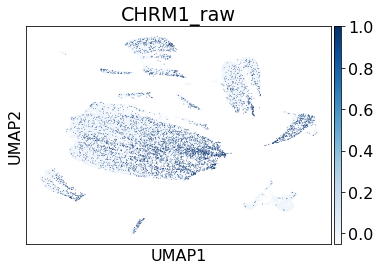

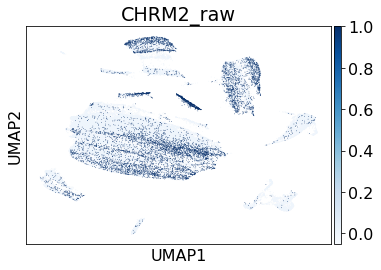

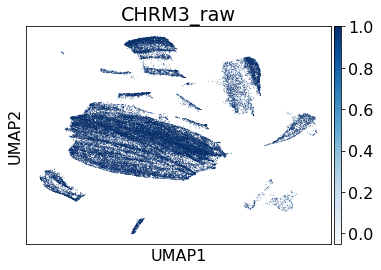

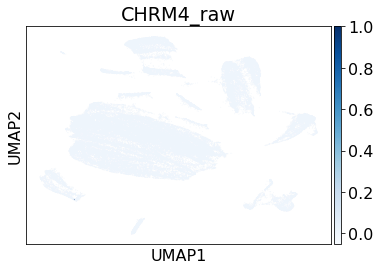

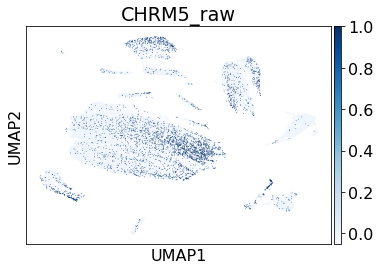

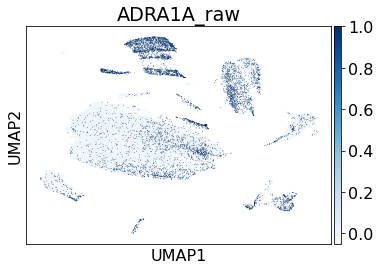

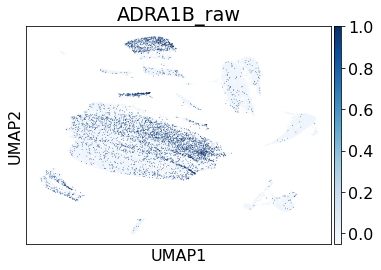

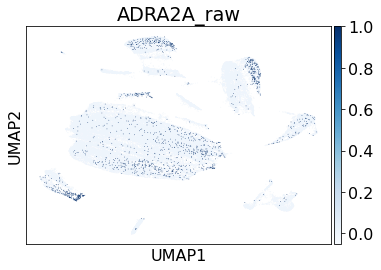

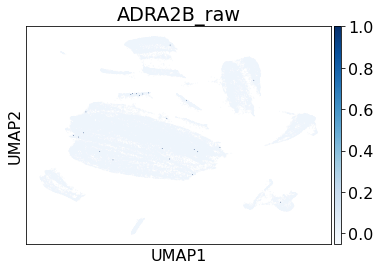

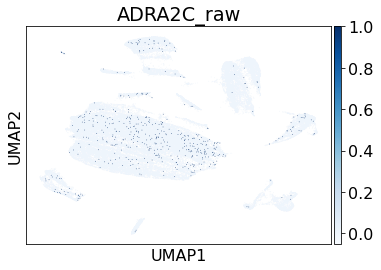

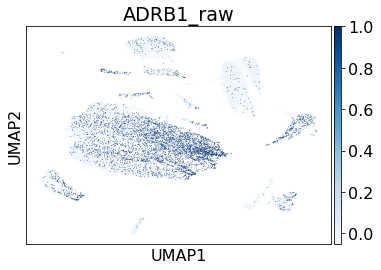

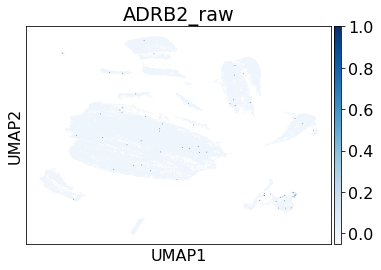

CPU times: user 9.42 s, sys: 105 ms, total: 9.53 s
Wall time: 9.48 s


In [36]:
%%time
#sc.pl.umap(adata, color=["Etv1_raw"], color_map="Reds", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Nos1_raw"], color_map="Reds", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Gad1_raw"], color_map="Blues", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Glp1r_raw"], color_map="Blues", vmax=1, vmin=-0.05)
for marker in markers:
    sc.pl.umap(adata, color=["%s_raw"%marker], color_map="Blues", vmax=1, vmin=-0.05)

In [28]:
import matplotlib.colors as colors
plt.rcParams["font.size"] = 16
fig,axes = plt.subplots(4, 11, figsize=(70,24), gridspec_kw={'wspace':0.3})
#print(len(ax_list[0]))
for idx,marker in enumerate(markers):
    q,mod=divmod(idx,11)
    #print(idx)
    #print(q)
    #print(mod)
    ax=axes[q,mod]
    ax1_dict = sc.pl.umap(adata, color=["%s_raw"%marker], color_map="Blues", vmax=1, vmin=-0.05,ax=ax,show=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(vmin=1E-1,vmax=1E+3),ax=ax_list[idx], show=False,color_map="bwr")
    #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
    #                                          vmin=-1.0, vmax=1.0, base=10)
fig.savefig("../data/human_PFC/pdf/marker_expression_scatter.pdf")
fig.savefig("../data/human_PFC/pdf/marker_expression_scatter.png")
plt.close()

In [40]:
plt.close()

In [23]:
import matplotlib.colors as colors
plt.rcParams["font.size"] = 14
fig,(ax_list) = plt.subplots(1, 9, figsize=(66,6), gridspec_kw={'wspace':0.3})
for idx,drug in enumerate(drug_list):
    ax=ax_list[idx]
    color_bar_option="None"
    if idx==len(ax_list):
        color_bar_option="right"
    ax1_dict = sc.pl.violin(adata, "cAMP_%s"%drug,groupby='leiden',stripplot=False,ax=ax_list[idx], show=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelrotation=90)
    #ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(vmin=1E-1,vmax=1E+3),ax=ax_list[idx], show=False,color_map="bwr")
    #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
    #                                          vmin=-1.0, vmax=1.0, base=10)
fig.savefig("../data/human_PFC/pdf/cAMP_response_bar.pdf")
fig.savefig("../data/human_PFC/pdf/cAMP_response_bar.png")
plt.close()

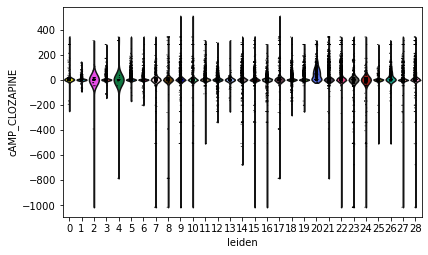

In [65]:
sc.pl.violin(adata, "cAMP_CLOZAPINE", groupby='leiden')

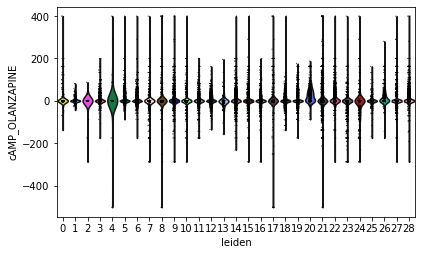

In [66]:
sc.pl.violin(adata, "cAMP_OLANZAPINE", groupby='leiden')

In [44]:
dir="../data/human_PFC/"
h5_fname=os.path.join(dir,"human_PFC_adata.h5ad")
adata.write(filename=h5_fname)

In [9]:
dir="../data/human_PFC/"
h5_fname=os.path.join(dir,"human_PFC_adata.h5ad")
adata=sc.read_h5ad(h5_fname)

In [10]:
adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
print(sum(adata.obs["is_clz_activated"]))

10394.0


In [11]:
adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")
print(sum(adata.obs["is_clz_inhibited"]))

1902.0


In [12]:
drug_receptor_mtx=pd.read_csv("../data/Antipsychotics/drug_receptor_mtx.csv")
GPCR_df=pd.read_csv("../data/Antipsychotics/GPCR_df.csv")

In [13]:
print(drug_receptor_mtx.columns)
d_r_column=drug_receptor_mtx.columns
d_r_column_rep=['Ligand',"HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]

drug_receptor_mtx.columns=d_r_column_rep
drug_receptor_mtx=drug_receptor_mtx.set_index("Ligand")
#print(drug_receptor_mtx.columns)

Index(['Ligand', '5-HT1A', '5-HT1B', '5-HT1D', '5-HT1E', '5-HT2A', '5-HT2B',
       '5-HT2C', '5-HT3', '5-HT4', '5-HT5', '5HT6', '5HT7', 'D1', 'D2', 'D3',
       'D4', 'D5', 'H1', 'H2', 'H3', 'M1', 'M2', 'M3', 'M4', 'M5', 'alpha1A',
       'alpha1B', 'alpha2A', 'alpha2B', 'alpha2C', 'beta1', 'beta2'],
      dtype='object')


In [14]:
drug_list=drug_receptor_mtx.index.to_list()
drug_list2=drug_list.copy()
drug_list2.remove("CLOZAPINE")
print(drug_list2)

for idx,drug in enumerate(drug_list2):
    #print(idx)
    if idx==0:
        cAMP_mean=adata.obs["cAMP_%s"%drug]
    else:
        cAMP_mean=cAMP_mean+adata.obs["cAMP_%s"%drug]
    #print(adata.obs["cAMP_%s"%drug])
cAMP_mean=cAMP_mean/len(drug_list2)
print(cAMP_mean)
adata.obs["cAMP_mean_other_than_czp"]=cAMP_mean
adata.obs["cAMP_clz_selectivity"]=adata.obs["cAMP_CLOZAPINE"]**2/cAMP_mean**2
print(sum(adata.obs["cAMP_clz_selectivity"]>1.5))
adata.obs["cAMP_clz_selectivity_over_olz"]=adata.obs["cAMP_CLOZAPINE"]**2/adata.obs["cAMP_OLANZAPINE"]**2

['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE', 'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE']
0         0.000000
1         1.279267
2         0.000000
3         0.000000
4        31.336362
           ...    
57045     0.000000
57046     0.000000
57047     0.000000
57048    11.015068
57049     0.000000
Length: 57050, dtype: float64
9812


In [30]:
selectivity_threshold=10
adata.obs["is_clz_selective"]=np.zeros(len(adata.obs))
adata.obs["is_clz_selective"][(adata.obs["cAMP_clz_selectivity"]>selectivity_threshold)&(adata.obs["cAMP_CLOZAPINE"]>0)]=1
adata.obs["is_clz_selective"]=adata.obs["is_clz_selective"].astype("category")
print(sum(adata.obs["is_clz_selective"]))

8901.0


In [31]:
selectivity_threshold=10
clz_vs_olz_threshold=4
adata.obs["is_clz_selective_over_olz"]=np.zeros(len(adata.obs))
adata.obs["is_clz_selective_over_olz"][(adata.obs["cAMP_clz_selectivity"]>selectivity_threshold)&(adata.obs["cAMP_CLOZAPINE"]>0)&(adata.obs["cAMP_clz_selectivity_over_olz"]>clz_vs_olz_threshold)]=1
adata.obs["is_clz_selective_over_olz"]=adata.obs["is_clz_selective_over_olz"].astype("category")
print(sum(adata.obs["is_clz_selective_over_olz"]))

3340.0


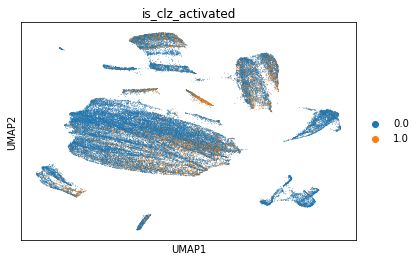

In [25]:
sc.pl.umap(adata, color=["is_clz_activated"])

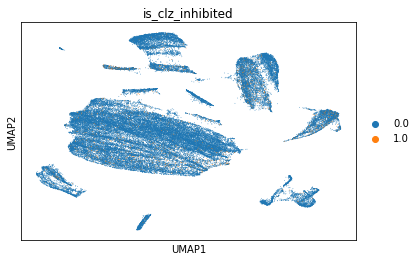

In [26]:
sc.pl.umap(adata, color=["is_clz_inhibited"])

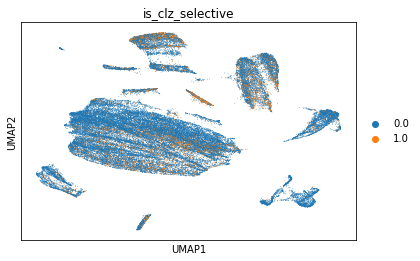

In [34]:
sc.pl.umap(adata, color=["is_clz_selective"])

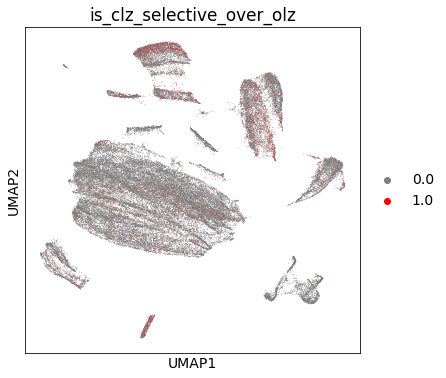

CPU times: user 2.86 s, sys: 4.18 ms, total: 2.86 s
Wall time: 2.86 s


In [39]:
%%time
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6), gridspec_kw={'wspace':0.2})
sc.pl.umap(adata, color=["is_clz_selective_over_olz"],ax=ax1,palette=["gray","red"])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/human_PFC/pdf/clz_selective_scatter.pdf",bbox_inches='tight')
fig.savefig("../data/human_PFC/pdf/clz_selective_scatter.png",bbox_inches='tight')
plt.close()

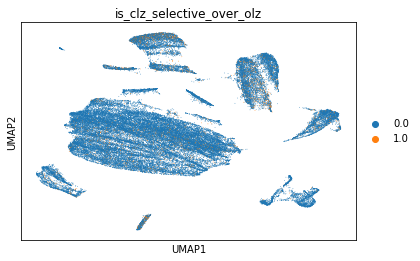

In [49]:
sc.pl.umap(adata, color=["is_clz_selective_over_olz"])

In [13]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

NameError: name 'drug_list' is not defined

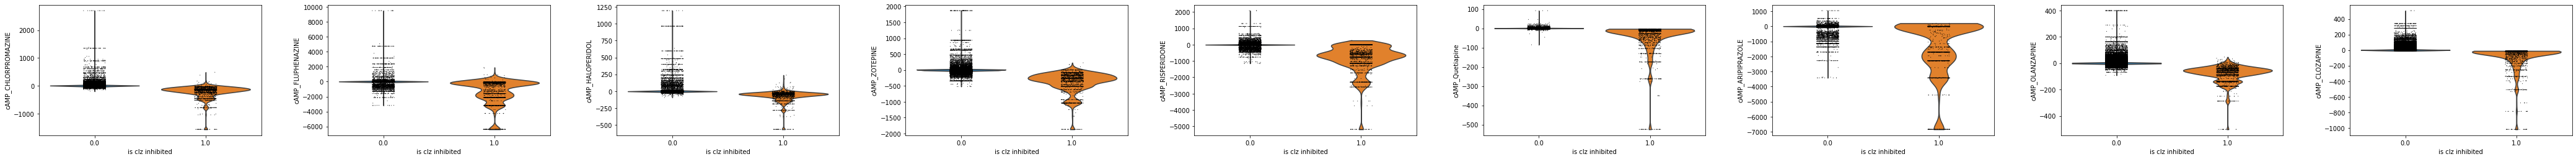

CPU times: user 4.14 s, sys: 11.2 s, total: 15.4 s
Wall time: 2.85 s


In [38]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

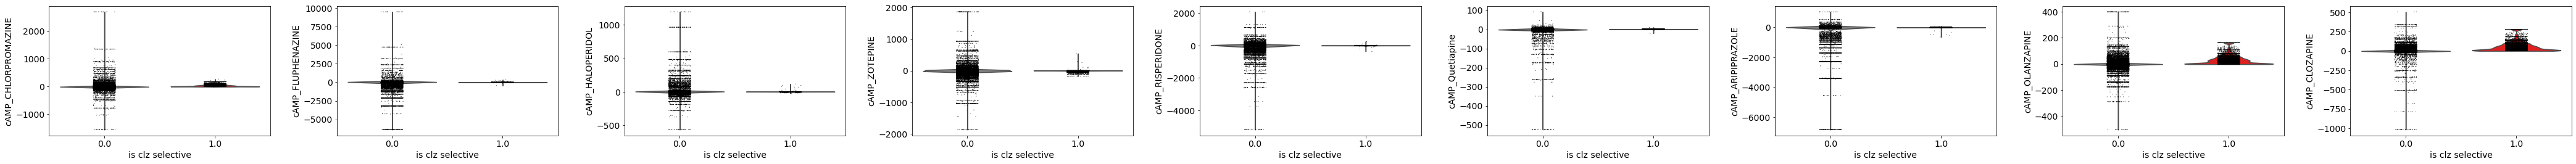

CPU times: user 6.98 s, sys: 11.2 s, total: 18.1 s
Wall time: 5.63 s


In [34]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

fig.tight_layout()
fig.savefig("../data/human_PFC/pdf/clz_selective_cAMP_response.pdf",bbox_inches='tight')
fig.savefig("../data/human_PFC/pdf/clz_selective_cAMP_response.png",bbox_inches='tight')
plt.close()

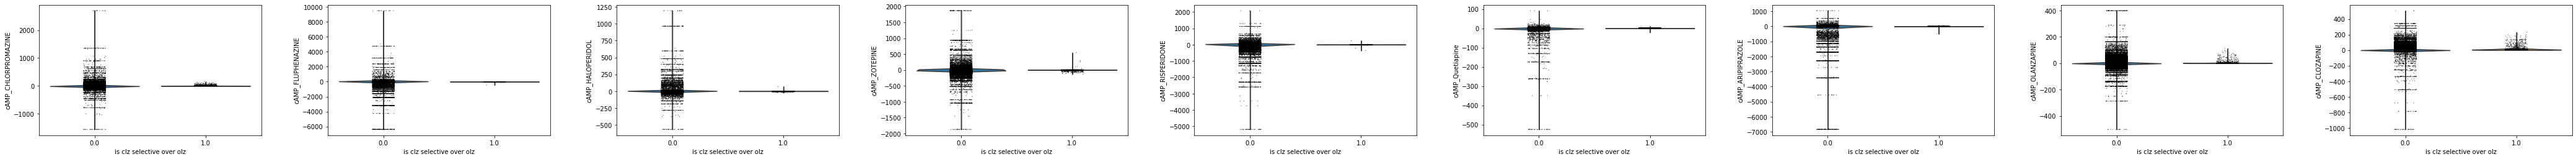

CPU times: user 4.31 s, sys: 10.9 s, total: 15.2 s
Wall time: 2.89 s


In [50]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective_over_olz')

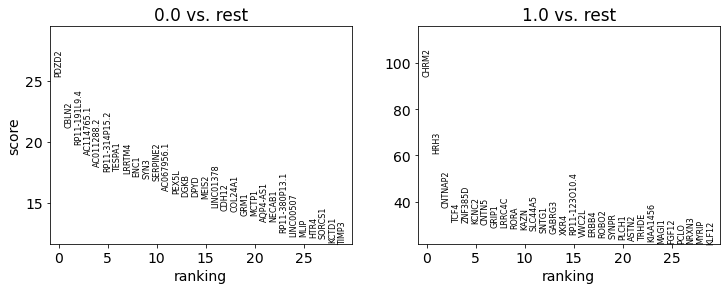

In [36]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)


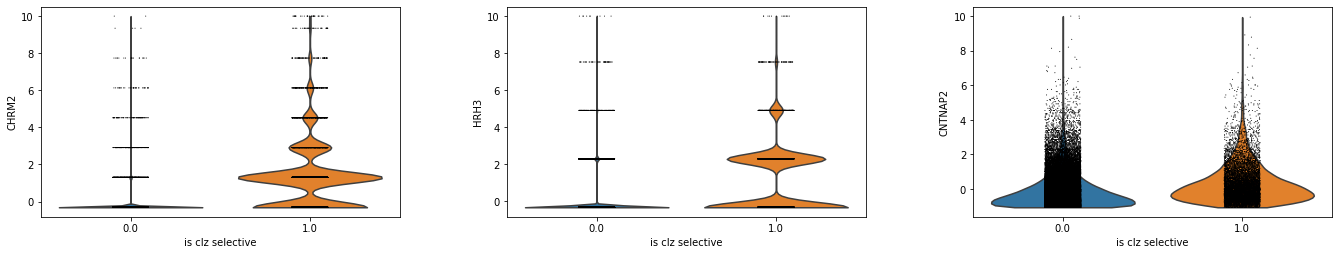

In [58]:
sc.pl.violin(adata, ['CHRM2', 'HRH3', 'CNTNAP2'], groupby='is_clz_selective')

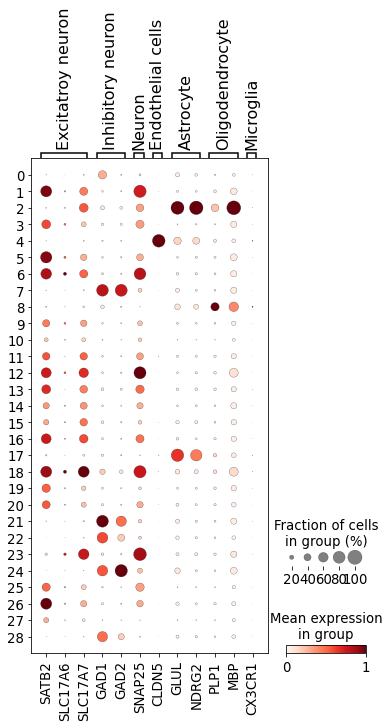

CPU times: user 1.1 s, sys: 144 ms, total: 1.25 s
Wall time: 1.1 s


In [ ]:
%%time
fig=plt.figure(figsize=(6,10))
ax1= fig.add_subplot(1,1,1)
sc.pl.dotplot(adata,marker_genes_dict, groupby="leiden",ax=ax1, standard_scale='var')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/human_PFC/pdf/marker_expression.pdf",bbox_inches='tight')
fig.savefig("../data/human_PFC/pdf/marker_expression.png",bbox_inches='tight')
plt.close()

<Figure size 432x720 with 0 Axes>

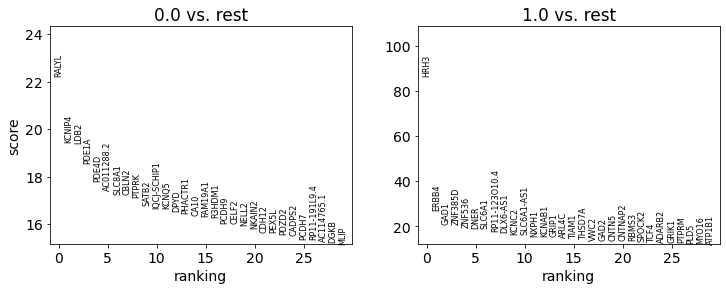

In [48]:
#sc.tl.rank_genes_groups(adata, 'is_clz_selective_over_olz', method='wilcoxon')
fig=plt.figure(figsize=(6,10))
#ax1= fig.add_subplot(1,1,1)
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False,save="clz_selective_over_olz_genes.pdf")
#fig.savefig("../data/human_PFC/pdf/clz_selective_over_olz_genes.pdf",bbox_inches='tight')
#fig.savefig("../data/human_PFC/pdf/clz_selective_over_olz_genes.png",bbox_inches='tight')
plt.close()

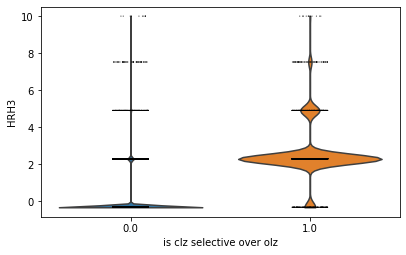

In [67]:
sc.pl.violin(adata, 'HRH3', groupby='is_clz_selective_over_olz')